---

# Let's Engineer the Features and Run the Model

First we should load the data.

---

In [65]:
import pandas as pd

# Load the data
data = pd.read_csv('csv/data_cleaned.csv')

# Display the first few rows of the dataframe
data.head()

,Date,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
0,2024-08-23,145,"Union Park, Illinois, United States",41.8839,-87.6648,-3.046968
1,2024-08-22,145,"Union Park, Illinois, United States",41.8839,-87.6648,0.000000
2,2024-08-20,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654
3,2024-08-20,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654
4,2024-06-27,145,"Buckingham Fountain, Illinois, United States",41.8756,-87.6189,-7.052186


---

Let's create our feature set. We've already engineered our labels.

---

### **Features as a Tensor**

The input data for the model is represented as a 3D tensor:

$$
\mathbf{X} \in \mathbb{R}^{B \times T \times F}
$$

Where:
- $ B $: Number of unique target dates in the label dataset that have at least $ T = 30 $ predecessor events.
- $ T = 30 $: Length of the sequence (time steps).
- $ F = 5 $: Number of features per time step.

---

### **Feature Definition**

For each row in the sequence:
$$
\mathbf{x}_t = [\text{event\_date}_t, \text{lat}_t, \text{long}_t, \text{score}_t, \text{target\_date}]
$$

- $ \text{event\_date}_t $: Date of the historical event at time step $ t $.
- $ \text{lat}_t, \text{long}_t $: Latitude and longitude of the event at time step $ t $.
- $ \text{score}_t $: Score of the event at time step $ t $.
- $ \text{target\_date} $: The specific date for which the model is predicting a score (constant across the sequence).

---

### **Matrix for a Single Sequence**

The feature matrix for one sequence is:

$$
\mathbf{X}_b =
\begin{bmatrix}
\text{event\_date}_1 & \text{lat}_1 & \text{long}_1 & \text{score}_1 & \text{target\_date} \\
\text{event\_date}_2 & \text{lat}_2 & \text{long}_2 & \text{score}_2 & \text{target\_date} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
\text{event\_date}_{30} & \text{lat}_{30} & \text{long}_{30} & \text{score}_{30} & \text{target\_date}
\end{bmatrix}
$$

Where:
$$
\mathbf{X}_b \in \mathbb{R}^{T \times F}
$$

---


In [66]:
X = []
target_dates = []

# Define the sequence length
sequence_length = 30

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Create a date range from the minimum date in the data to today
date_range = pd.date_range(start=data['Date'].min(), end=pd.Timestamp.today())

# Iterate through each date in the date range
for target_date in date_range:
    # Get rows with event dates before the target date
    historical_data = data[data['Date'] < target_date]

    # Check if there are at least sequence_length rows
    if len(historical_data) >= sequence_length:
        # Get the last sequence_length rows
        tensor = historical_data.iloc[-sequence_length:].copy()
        # Drop the EventCode and ActionGeo_FullName columns
        tensor = tensor.drop(columns=['EventCode', 'ActionGeo_FullName'])
        # Add the target date as a new column
        tensor['TargetDate'] = target_date
        X.append(tensor)
        target_dates.append(target_date)

X

[           Date  ActionGeo_Lat  ActionGeo_Long    AvgTone TargetDate
 3465 2015-05-06          41.85        -87.6501 -12.637363 2015-05-07
 3466 2015-05-02          41.85        -87.6501  -4.844961 2015-05-07
 3467 2015-05-02          41.85        -87.6501  -4.844961 2015-05-07
 3468 2015-05-01          41.85        -87.6501  -2.613480 2015-05-07
 3469 2015-05-01          41.85        -87.6501  -2.613480 2015-05-07
 3470 2015-04-30          41.85        -87.6501  -8.982036 2015-05-07
 3471 2015-04-30          41.85        -87.6501  -0.915751 2015-05-07
 3472 2015-04-30          41.85        -87.6501  -8.982036 2015-05-07
 3473 2015-04-29          41.85        -87.6501  -5.829904 2015-05-07
 3474 2015-04-29          41.85        -87.6501  -4.885057 2015-05-07
 3475 2015-04-28          41.85        -87.6501 -11.785400 2015-05-07
 3476 2015-04-28          41.85        -87.6501 -11.785400 2015-05-07
 3477 2015-04-28          41.85        -87.6501 -11.785400 2015-05-07
 3478 2015-04-28    

---

Let's see if they were correctly imported.

---

In [67]:
# Print the number of sequences
print(f"Number of sequences: {len(X)}")

# Print the shape of the first sequence as an example
if len(X) > 0:
    print(f"Shape of the first sequence: {X[0].shape}")

Number of sequences: 3524
Shape of the first sequence: (30, 5)


In [68]:
# Display the first sequence
print("First sequence:")
display(X[0].head())

#print("\nSecond sequence:")
#display(X[1].drop(columns=['TargetDate']))

#print("\nThird sequence:")
#display(X[2].drop(columns=['TargetDate']))

# Iterate through rows of X[1] and X[2] and print the differences in one line
for row1, row2 in zip(X[1].drop(columns=['TargetDate']).itertuples(index=False), X[2].drop(columns=['TargetDate']).itertuples(index=False)):
    differences = [val1 - val2 for val1, val2 in zip(row1, row2)]
    #print(f"Differences: {differences}")


First sequence:


,Date,ActionGeo_Lat,ActionGeo_Long,AvgTone,TargetDate
3465,2015-05-06,41.85,-87.6501,-12.637363,2015-05-07
3466,2015-05-02,41.85,-87.6501,-4.844961,2015-05-07
3467,2015-05-02,41.85,-87.6501,-4.844961,2015-05-07
3468,2015-05-01,41.85,-87.6501,-2.613480,2015-05-07
3469,2015-05-01,41.85,-87.6501,-2.613480,2015-05-07


---

Looks like the features are propperly engineered into the tensor!

You can un-comment the prints above to compare. It looks correct to me.

---

---

### **Label Definition**

The label for each sequence ($ b $) corresponds to the score for the target date:
$$
y_b = \text{score}_{\text{target\_date}}
$$

The label vector for all batches is:
$$
\mathbf{y} \in \mathbb{R}^B
$$

---

In [69]:
# Load the scored events data
Y = pd.read_csv('model_csv/daily_score.csv')

# Display the first few rows of the dataframe
Y.head()

,Date,Total Score
0,2015-12-25,-589.428382
1,2015-12-26,0.000000
2,2015-12-27,0.000000
3,2015-12-28,0.000000
4,2015-12-29,0.000000


In [70]:
# Convert 'Date' column in Y to datetime format
Y['Date'] = pd.to_datetime(Y['Date'])

# Find the intersection of target dates in X and dates in Y
common_dates = set(target_dates).intersection(set(Y['Date']))

# Filter X and target_dates to only include sequences with common dates
filtered_X = [seq for seq, date in zip(X, target_dates) if date in common_dates]
filtered_target_dates = [date for date in target_dates if date in common_dates]

# Update the X and target_dates variables
X = filtered_X
target_dates = filtered_target_dates

# Print the first and last target dates in X
print(f"First target date in X: {X[0]['TargetDate'].iloc[0]}")
print(f"Last target date in X: {X[-1]['TargetDate'].iloc[0]}")

# Print the first and last dates in Y
print(f"First date in Y: {Y['Date'].iloc[0]}")
print(f"Last date in Y: {Y['Date'].iloc[-1]}")

First target date in X: 2015-12-25 00:00:00
Last target date in X: 2024-12-28 00:00:00
First date in Y: 2015-12-25 00:00:00
Last date in Y: 2024-12-28 00:00:00


--- 

# Test Train Split

I want to capture a really bad protest, and then see if it can predict some of the events in 2023. Splitting on 2021 seems like a solid choice to capture both types of events.

---

In [71]:
# Split the data into before and after 2021
Y_train = Y[Y['Date'] < '2021-01-01']
Y_test = Y[Y['Date'] >= '2021-01-01']

# Display the resulting dataframes
print("Train Data:")
display(Y_train)
print("\nTest Data:")
display(Y_test)

# Add sequences from X to the split data
X_train = [seq for seq, date in zip(X, target_dates) if date < pd.Timestamp('2021-01-01')]
X_test = [seq for seq, date in zip(X, target_dates) if date >= pd.Timestamp('2021-01-01')]

# Display the number of sequences in each split
print(f"Number of sequences in X_train: {len(X_train)}")
print(f"Number of sequences in X_test: {len(X_test)}")

Train Data:


,Date,Total Score
0,2015-12-25,-589.428382
1,2015-12-26,0.000000
2,2015-12-27,0.000000
3,2015-12-28,0.000000
4,2015-12-29,0.000000
...,...,...
1829,2020-12-27,0.000000
1830,2020-12-28,0.000000
1831,2020-12-29,0.000000
1832,2020-12-30,0.000000



Test Data:


,Date,Total Score
1834,2021-01-01,0.0
1835,2021-01-02,0.0
1836,2021-01-03,0.0
1837,2021-01-04,0.0
1838,2021-01-05,0.0
...,...,...
3287,2024-12-24,0.0
3288,2024-12-25,0.0
3289,2024-12-26,0.0
3290,2024-12-27,0.0


Number of sequences in X_train: 1834
Number of sequences in X_test: 1458


---

# LSTM Model

---

In [74]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Prepare the data
def prepare_data(X, Y, target_dates):
    X_data = np.array([seq.drop(columns=['TargetDate']).select_dtypes(include=[np.number]).values for seq in X])
    Y_data = []
    for date in target_dates:
        score = Y[Y['Date'] == date]['Total Score']
        if not score.empty:
            Y_data.append(score.values[0])
        else:
            Y_data.append(np.nan)  # Handle missing dates by appending NaN
    Y_data = np.array(Y_data)
    return X_data, Y_data

# Filter target dates to only include those present in Y_train and Y_test
filtered_train_dates = [date for date in filtered_target_dates if date in Y_train['Date'].values]
filtered_test_dates = [date for date in filtered_target_dates if date in Y_test['Date'].values]

X_train_data, Y_train_data = prepare_data(X_train, Y_train, filtered_train_dates)
X_test_data, Y_test_data = prepare_data(X_test, Y_test, filtered_test_dates)

# Remove sequences with NaN values in Y_train_data and Y_test_data
train_mask = ~np.isnan(Y_train_data)
test_mask = ~np.isnan(Y_test_data)
X_train_data, Y_train_data = X_train_data[train_mask], Y_train_data[train_mask]
X_test_data, Y_test_data = X_test_data[test_mask], Y_test_data[test_mask]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_data.shape[1], X_train_data.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train_data, Y_train_data, epochs=50, batch_size=32, validation_data=(X_test_data, Y_test_data))

# Evaluate the model
loss = model.evaluate(X_test_data, Y_test_data)
print(f'Test Loss: {loss}')

Epoch 1/50


/opt/anaconda3/envs/civil_unrest/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 391881.8750 - val_loss: 143076.1250
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 394760.8750 - val_loss: 142974.5000
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 554415.6250 - val_loss: 142928.1562
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 293047.1250 - val_loss: 142894.6719
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 381722.8750 - val_loss: 142867.3750
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 354303.3750 - val_loss: 142845.1406
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 307786.2500 - val_loss: 142827.9375
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 417400.4375 - val_loss: 142813.8438
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 308285.1562 - val_loss: 142803.8906
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 545658.8750 - val_loss: 142796.0781
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 

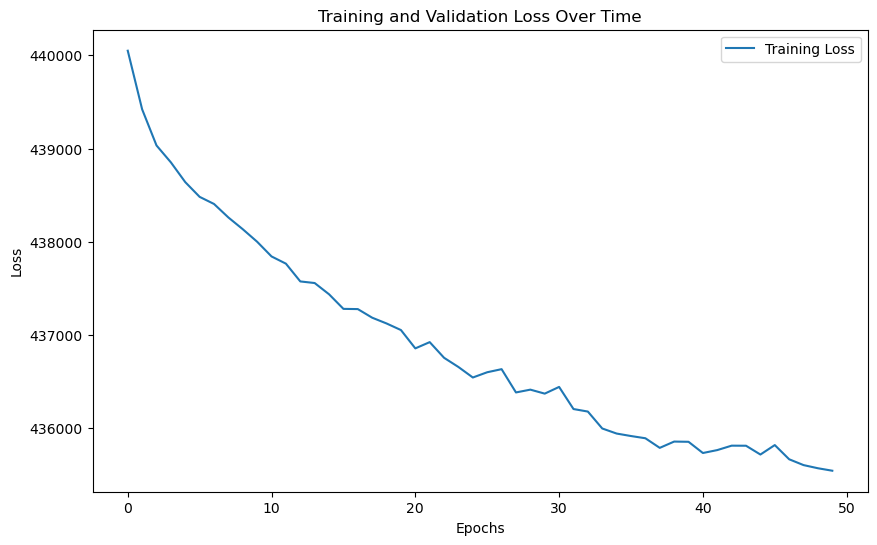

In [76]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()